In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import dataframe_image as dfi
from io import BytesIO
from IPython.display import Image

In [2]:
# Portfolio Log Returns

cols = ['Date', 'Close', 'Volume', 'Share Turnover', 'Weighted ST']
pltr = pd.read_csv("PALANTIR_MAIN.csv", usecols=cols)
uipath = pd.read_csv("UIPATH_MAIN.csv", usecols=cols)
bbai = pd.read_csv("BBAI_MAIN.csv", usecols=cols)
c3ai = pd.read_csv("C3AI_MAIN.csv", usecols=cols)

pltr['Log Return'] = np.log(pltr['Close'] / pltr['Close'].shift(1))
c3ai['Log Return'] = np.log(c3ai['Close'] / c3ai['Close'].shift(1))
bbai['Log Return'] = np.log(bbai['Close'] / bbai['Close'].shift(1))
uipath['Log Return'] = np.log(uipath['Close'] / uipath['Close'].shift(1))

portfolio_log_return = (
    0.4 * pltr['Log Return'] +
    0.4 * c3ai['Log Return'] +
    0.1 * uipath['Log Return'] +
    0.1 * bbai['Log Return']
)

portfolio = pd.DataFrame()
portfolio['Date'] = pltr['Date']  # Align on the same dates
portfolio['Portfolio Log Return'] = portfolio_log_return
portfolio['Date'] = pd.to_datetime(portfolio['Date'])

C:\Users\tural\AppData\Local\Temp\ipykernel_12188\258093239.py:24: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  portfolio['Date'] = pd.to_datetime(portfolio['Date'])


In [3]:
# Momentum of stocks

stocks = pd.DataFrame()
stocks['Close'] = (
    0.4 * pltr['Close'] +
    0.4 * c3ai['Close'] +
    0.1 * uipath['Close'] +
    0.1 * bbai['Close']
)

stocks['Momentum_4W'] = np.log(stocks['Close']/stocks['Close'].shift(4)) / np.log(stocks['Close'].shift(4))
#stocks['Momentum_4W_diff'] = stocks['Momentum_4W'] - stocks['Momentum_4W'].shift(1)

stocks = stocks.dropna()

In [4]:
# Feature selection and normalization

ST_main = pd.read_csv('ST_MAIN.csv')
VXN = pd.read_csv('VXN_data.csv')
VXN['d_VXN'] = np.log(VXN['Close'] / VXN['Close'].shift(1))
ST_main['d_ST'] = np.log(ST_main['Share Turnover'] / ST_main['Share Turnover'].shift(1))

In [5]:
# Scaling

scaler = StandardScaler()
portfolio['Portfolio Log Return'] = scaler.fit_transform(portfolio[['Portfolio Log Return']])
ST_main['delta_ST'] = scaler.fit_transform(ST_main[['d_ST']])
VXN['delta_VXN'] = scaler.fit_transform(VXN[['d_VXN']])
stocks['Momentum_4W'] = scaler.fit_transform(stocks[['Momentum_4W']])
#stocks['Momentum_4W_diff'] = scaler.fit_transform(stocks[['Momentum_4W_diff']])

In [6]:
# CEFD preprocessing

CEFD = pd.read_csv('CEFD_MAIN')
CEFD['Discounts'] = CEFD['Discount'] * 100 * -1
scaler = MinMaxScaler()
CEFD['Normalized Discount'] = scaler.fit_transform(CEFD[['Discounts']])

num = []
for i in range(len(CEFD['Normalized Discount'])):
    if CEFD['Normalized Discount'][i] == 0:
        num.append(i)
if num != []:
    CEFD['Normalized Discount'][num[0]] = (CEFD['Normalized Discount'][num[0]-1] + 
                                       CEFD['Normalized Discount'][num[0]+1]) / 2

CEFD['d_CEFD'] = np.log(CEFD['Normalized Discount'] / CEFD['Normalized Discount'].shift(1))

C:\Users\tural\AppData\Local\Temp\ipykernel_12188\3450137785.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CEFD['Normalized Discount'][num[0]] = (CEFD['Normalized Discount'][num[0]-1] +


In [7]:
scaler = StandardScaler()
CEFD['d_CEFD'] = scaler.fit_transform(CEFD[['d_CEFD']])

In [8]:
CEFD

,Unnamed: 0,Discount,Date,Discounts,Normalized Discount,d_CEFD
0,0,-0.005974,2021-04-23,0.597423,0.231482,NaN
1,1,0.009277,2021-04-30,-0.927741,0.124045,-2.146840
2,2,0.002999,2021-05-07,-0.299919,0.168270,1.022459
3,3,0.002260,2021-05-14,-0.226041,0.173474,0.085884
4,4,0.007602,2021-05-21,-0.760166,0.135849,-0.852306
...,...,...,...,...,...,...
180,180,-0.070660,2024-10-04,7.065966,0.687144,-0.220638
181,181,-0.073396,2024-10-11,7.339617,0.706421,0.076359
182,182,-0.068948,2024-10-18,6.894760,0.675084,-0.172881
183,183,-0.069703,2024-10-25,6.970342,0.680408,0.008756


In [9]:
# Data formation

data = pd.DataFrame({
    'Portfolio Log Return': portfolio['Portfolio Log Return'],
    'd_ST Lag 2': ST_main['delta_ST'].shift(2),
    'd_ST Lag 1': ST_main['delta_ST'].shift(1),
    'd_ST': ST_main['delta_ST'],
    'd_VXN': VXN['delta_VXN'],
    'Momentum 4W': stocks['Momentum_4W'],
    #'Momentum_4W_diff': stocks['Momentum_4W_diff'],
    'd_CEFD Lag 1': CEFD['d_CEFD'].shift(1),
    'd_CEFD Lag 2': CEFD['d_CEFD'].shift(2),
    'd_CEFD': CEFD['d_CEFD']
})

In [10]:
data = data.dropna()

In [11]:
data

,Portfolio Log Return,d_ST Lag 2,d_ST Lag 1,d_ST,d_VXN,Momentum 4W,d_CEFD Lag 1,d_CEFD Lag 2,d_CEFD
4,1.147260,0.923899,0.854190,-1.605248,-0.291029,-0.367342,0.085884,1.022459,-0.852306
5,0.599256,0.854190,-1.605248,0.341820,-1.289575,-0.099678,-0.852306,0.085884,-0.450003
6,0.429735,-1.605248,0.341820,0.916620,-0.109382,0.589927,-0.450003,-0.852306,-8.161845
7,-0.210707,0.341820,0.916620,0.655403,-1.052325,0.595113,-8.161845,-0.450003,6.634204
8,0.031858,0.916620,0.655403,-0.931871,1.615029,0.019636,6.634204,-8.161845,2.095237
...,...,...,...,...,...,...,...,...,...
180,0.353910,0.548978,-1.466745,-0.131148,0.785516,1.049165,0.105855,-0.032291,-0.220638
181,1.163798,-1.466745,-0.131148,0.504159,0.751288,0.875164,-0.220638,0.105855,0.076359
182,-0.182273,-0.131148,0.504159,0.144159,-0.701374,0.595237,0.076359,-0.220638,-0.172881
183,-0.014582,0.504159,0.144159,-0.923503,0.672414,0.626897,-0.172881,0.076359,0.008756


How to choose the best features?

Feature Importance using Random Forest Regressor
We divide our dataset to 3 timespans, in order to the overall effect of general, post and pre gpt eras

In [613]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [614]:
def feature_importance(timespan, dataframe, cols):
    if timespan == "all":
        df = dataframe
        plotname = "Feature importances using Random Forest Regressor"
    elif timespan == "postgpt":
        df = dataframe[89:]
        plotname = "Feature importances using Random Forest Regressor (After AI Hype)"
    elif timespan == "pregpt":
        df = dataframe[:89]
        plotname = "Feature importances using Random Forest Regressor (Before AI Hype)"
    else:
        raise ValueError("Invalid timespan value. Must be 'all', 'postgpt', or 'pregpt'.")

    X = df[cols]
    y = df.drop(columns=cols)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    forest = RandomForestRegressor(max_depth=2, random_state=0)
    forest.fit(X_train, y_train)

    importances = forest.feature_importances_
    forest_importances = pd.Series(importances, index=X.columns)
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title(plotname)
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

    return forest_importances.sort_values(ascending=False)

In [615]:
columns = ['d_ST Lag 2', 'd_ST Lag 1', 'd_ST', 'Momentum 4W', 'd_VXN',
       'd_CEFD Lag 1', 'd_CEFD Lag 2', 'd_CEFD']
era = "postgpt"

C:\Users\tural\anaconda3\envs\Hands_on_ML\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Momentum 4W     0.392760
d_ST            0.288273
d_VXN           0.166244
d_CEFD          0.086794
d_ST Lag 1      0.029723
d_CEFD Lag 2    0.016757
d_ST Lag 2      0.013146
d_CEFD Lag 1    0.006304
dtype: float64

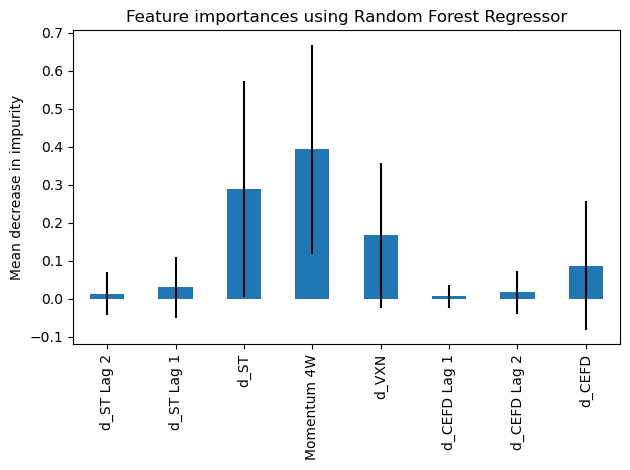

In [594]:
feature_importance(timespan = "all", dataframe = data, cols=columns)

C:\Users\tural\anaconda3\envs\Hands_on_ML\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Momentum 4W     0.393312
d_VXN           0.323447
d_ST            0.203885
d_ST Lag 1      0.024509
d_CEFD Lag 1    0.016188
d_ST Lag 2      0.015003
d_CEFD          0.013479
d_CEFD Lag 2    0.010178
dtype: float64

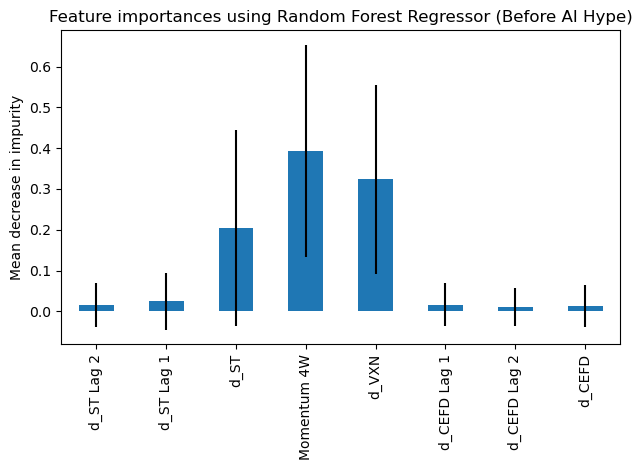

In [329]:
feature_importance(timespan = "pregpt", dataframe = data, cols=columns)

C:\Users\tural\anaconda3\envs\Hands_on_ML\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


d_ST            0.278537
Momentum 4W     0.193393
d_CEFD          0.162220
d_VXN           0.140315
d_CEFD Lag 1    0.094786
d_ST Lag 1      0.051441
d_CEFD Lag 2    0.048125
d_ST Lag 2      0.031182
dtype: float64

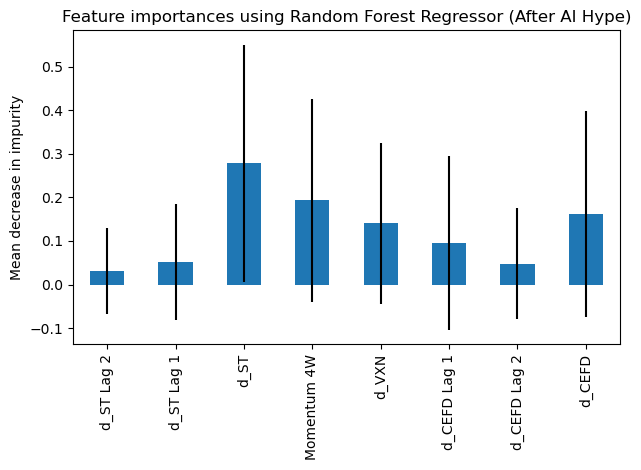

In [330]:
feature_importance(timespan = "postgpt", dataframe = data, cols=columns)

Correlation Analysis

<Axes: >

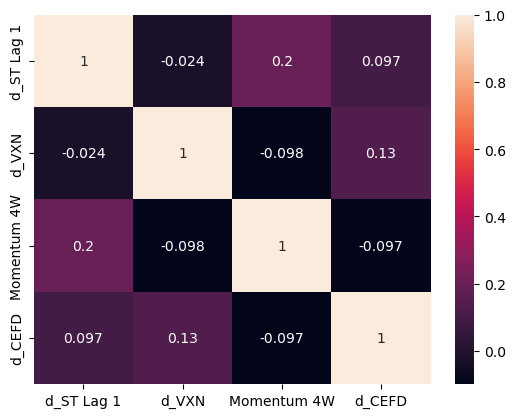

In [331]:
corr = data[['d_ST Lag 1', 'd_VXN', 'Momentum 4W', 'd_CEFD']].corr()
sns.heatmap(corr, annot=True)

In [277]:
# X = data[['d_ST Lag 1', 'd_VXN', 'Momentum 4W', 'd_CEFD']].dropna()
# vif_data = pd.DataFrame({
#     'feature': X.columns,
#     'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# })

# vif_data_styled = (vif_data
#                    .style
#                    .background_gradient(cmap='Blues', subset=['VIF'])
#                    .format({'VIF': '{:.2f}'}))
# vif_data_styled

# buf = BytesIO()
# dfi.export(
#     vif_data_styled,
#     buf,
#     table_conversion='matplotlib',
#     dpi=300      # Increase DPI for higher resolution
# )
# buf.seek(0)

# # Display the image inline with higher resolution
# Image(buf.read())

Regression Analysis

In [306]:
some_data = data[['d_ST Lag 1',
                  'd_VXN',
                  'd_CEFD',
                  'Momentum 4W',
                  'Portfolio Log Return',
                  #'Momentum_4W_diff'
                 ]]

In [307]:
from statsmodels.tsa.stattools import adfuller

In [603]:
for col in some_data.columns:
    # Drop missing values if any
    series = some_data[col].dropna()
    
    # Perform ADF test
    result = adfuller(series)
    
    # Extract results
    adf_stat = result[0]
    p_value = result[1]
    critical_values = result[4]

    # Print summary
    print(f"\n--- ADF Test for {col} ---")
    print(f"ADF Statistic: {adf_stat}")
    print(f"P-Value: {p_value}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"   {key}: {value}")

    # Interpretation
    if p_value < 0.05:
        print(f"{col} is likely stationary (rejecting the null hypothesis of a unit root).")
    else:
        print(f"{col} is likely non-stationary (cannot reject the null hypothesis).")


--- ADF Test for d_ST Lag 1 ---
ADF Statistic: -5.793340060771741
P-Value: 4.815122545369014e-07
Critical Values:
   1%: -3.469413468959902
   5%: -2.8786964197028295
   10%: -2.5759166089965397
d_ST Lag 1 is likely stationary (rejecting the null hypothesis of a unit root).

--- ADF Test for d_VXN ---
ADF Statistic: -8.531154784912163
P-Value: 1.0368300993848003e-13
Critical Values:
   1%: -3.467845319799907
   5%: -2.878011745497439
   10%: -2.575551186759871
d_VXN is likely stationary (rejecting the null hypothesis of a unit root).

--- ADF Test for d_CEFD ---
ADF Statistic: -16.41956945903323
P-Value: 2.538013771293482e-29
Critical Values:
   1%: -3.467631519151906
   5%: -2.8779183721695567
   10%: -2.575501353364474
d_CEFD is likely stationary (rejecting the null hypothesis of a unit root).

--- ADF Test for Momentum 4W ---
ADF Statistic: -2.3361130091928697
P-Value: 0.16058512624994115
Critical Values:
   1%: -3.470126426071447
   5%: -2.8790075987120027
   10%: -2.5760826967621

In [332]:
data

,Portfolio Log Return,d_ST Lag 2,d_ST Lag 1,d_ST,d_VXN,Momentum 4W,d_CEFD Lag 1,d_CEFD Lag 2,d_CEFD
4,1.147260,0.923899,0.854190,-1.605248,-0.291029,-0.367342,0.085884,1.022459,-0.852306
5,0.599256,0.854190,-1.605248,0.341820,-1.289575,-0.099678,-0.852306,0.085884,-0.450003
6,0.429735,-1.605248,0.341820,0.916620,-0.109382,0.589927,-0.450003,-0.852306,-8.161845
7,-0.210707,0.341820,0.916620,0.655403,-1.052325,0.595113,-8.161845,-0.450003,6.634204
8,0.031858,0.916620,0.655403,-0.931871,1.615029,0.019636,6.634204,-8.161845,2.095237
...,...,...,...,...,...,...,...,...,...
180,0.353910,0.548978,-1.466745,-0.131148,0.785516,1.049165,0.105855,-0.032291,-0.220638
181,1.163798,-1.466745,-0.131148,0.504159,0.751288,0.875164,-0.220638,0.105855,0.076359
182,-0.182273,-0.131148,0.504159,0.144159,-0.701374,0.595237,0.076359,-0.220638,-0.172881
183,-0.014582,0.504159,0.144159,-0.923503,0.672414,0.626897,-0.172881,0.076359,0.008756


In [12]:
X = data[['d_ST',
          'd_VXN',
          'd_CEFD Lag 1',
          'Momentum 4W'
         ]]
X = sm.add_constant(X)
Y = data['Portfolio Log Return']

model = sm.OLS(Y, X).fit()

nw_se_model = model.get_robustcov_results(cov_type='HAC', maxlags=1)

print(nw_se_model.summary())

                             OLS Regression Results                             
Dep. Variable:     Portfolio Log Return   R-squared:                       0.439
Model:                              OLS   Adj. R-squared:                  0.426
Method:                   Least Squares   F-statistic:                     31.43
Date:                  Fri, 27 Dec 2024   Prob (F-statistic):           9.51e-20
Time:                          17:04:29   Log-Likelihood:                -204.63
No. Observations:                   181   AIC:                             419.3
Df Residuals:                       176   BIC:                             435.2
Df Model:                             4                                         
Covariance Type:                    HAC                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0107     

In [13]:
data_postgpt = data[89:]

X = data_postgpt[['d_ST',
                 'd_VXN',
                 'd_CEFD',
                 'Momentum 4W'
                 ]]
X = sm.add_constant(X)
Y = data_postgpt['Portfolio Log Return']

model = sm.OLS(Y, X).fit()

nw_se_model = model.get_robustcov_results(cov_type='HAC', maxlags=1)

print(nw_se_model.summary())

                             OLS Regression Results                             
Dep. Variable:     Portfolio Log Return   R-squared:                       0.514
Model:                              OLS   Adj. R-squared:                  0.491
Method:                   Least Squares   F-statistic:                     25.42
Date:                  Fri, 27 Dec 2024   Prob (F-statistic):           5.79e-14
Time:                          17:04:31   Log-Likelihood:                -106.07
No. Observations:                    92   AIC:                             222.1
Df Residuals:                        87   BIC:                             234.8
Df Model:                             4                                         
Covariance Type:                    HAC                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0414      0.

In [14]:
data_pregpt = data[:89]

X = data_pregpt[['d_ST',
                 'd_VXN',
                 'd_CEFD',
                 'Momentum 4W'
         ]]
X = sm.add_constant(X)
Y = data_pregpt['Portfolio Log Return']

model = sm.OLS(Y, X).fit()

nw_se_model = model.get_robustcov_results(cov_type='HAC', maxlags=1)

print(nw_se_model.summary())

                             OLS Regression Results                             
Dep. Variable:     Portfolio Log Return   R-squared:                       0.408
Model:                              OLS   Adj. R-squared:                  0.380
Method:                   Least Squares   F-statistic:                     24.64
Date:                  Fri, 27 Dec 2024   Prob (F-statistic):           1.65e-13
Time:                          17:04:32   Log-Likelihood:                -90.440
No. Observations:                    89   AIC:                             190.9
Df Residuals:                        84   BIC:                             203.3
Df Model:                             4                                         
Covariance Type:                    HAC                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0330      0.

Reduce features into one Sentiment Index using PCA

In [15]:
from sklearn.decomposition import PCA as sklearnPCA

In [20]:
data.head()

,Portfolio Log Return,d_ST Lag 2,d_ST Lag 1,d_ST,d_VXN,Momentum 4W,d_CEFD Lag 1,d_CEFD Lag 2,d_CEFD
4,1.147260,0.923899,0.854190,-1.605248,-0.291029,-0.367342,0.085884,1.022459,-0.852306
5,0.599256,0.854190,-1.605248,0.341820,-1.289575,-0.099678,-0.852306,0.085884,-0.450003
6,0.429735,-1.605248,0.341820,0.916620,-0.109382,0.589927,-0.450003,-0.852306,-8.161845
7,-0.210707,0.341820,0.916620,0.655403,-1.052325,0.595113,-8.161845,-0.450003,6.634204
8,0.031858,0.916620,0.655403,-0.931871,1.615029,0.019636,6.634204,-8.161845,2.095237


In [160]:
X = data[[#'d_ST Lag 1',
          #'d_ST Lag 2',
          'd_ST',
          'd_VXN',
          'd_CEFD',
          #'d_CEFD Lag 1',
          #'d_CEFD Lag 2',
          'Momentum 4W',
         ]]
X = sm.add_constant(X)
Y = data['Portfolio Log Return']

In [161]:
sklearn_pca = sklearnPCA(n_components=1)
X_pca = sklearn_pca.fit_transform(X)

sklearn_pca.explained_variance_ratio_

array([0.33209119])

In [45]:
# portfolio = portfolio[4:]

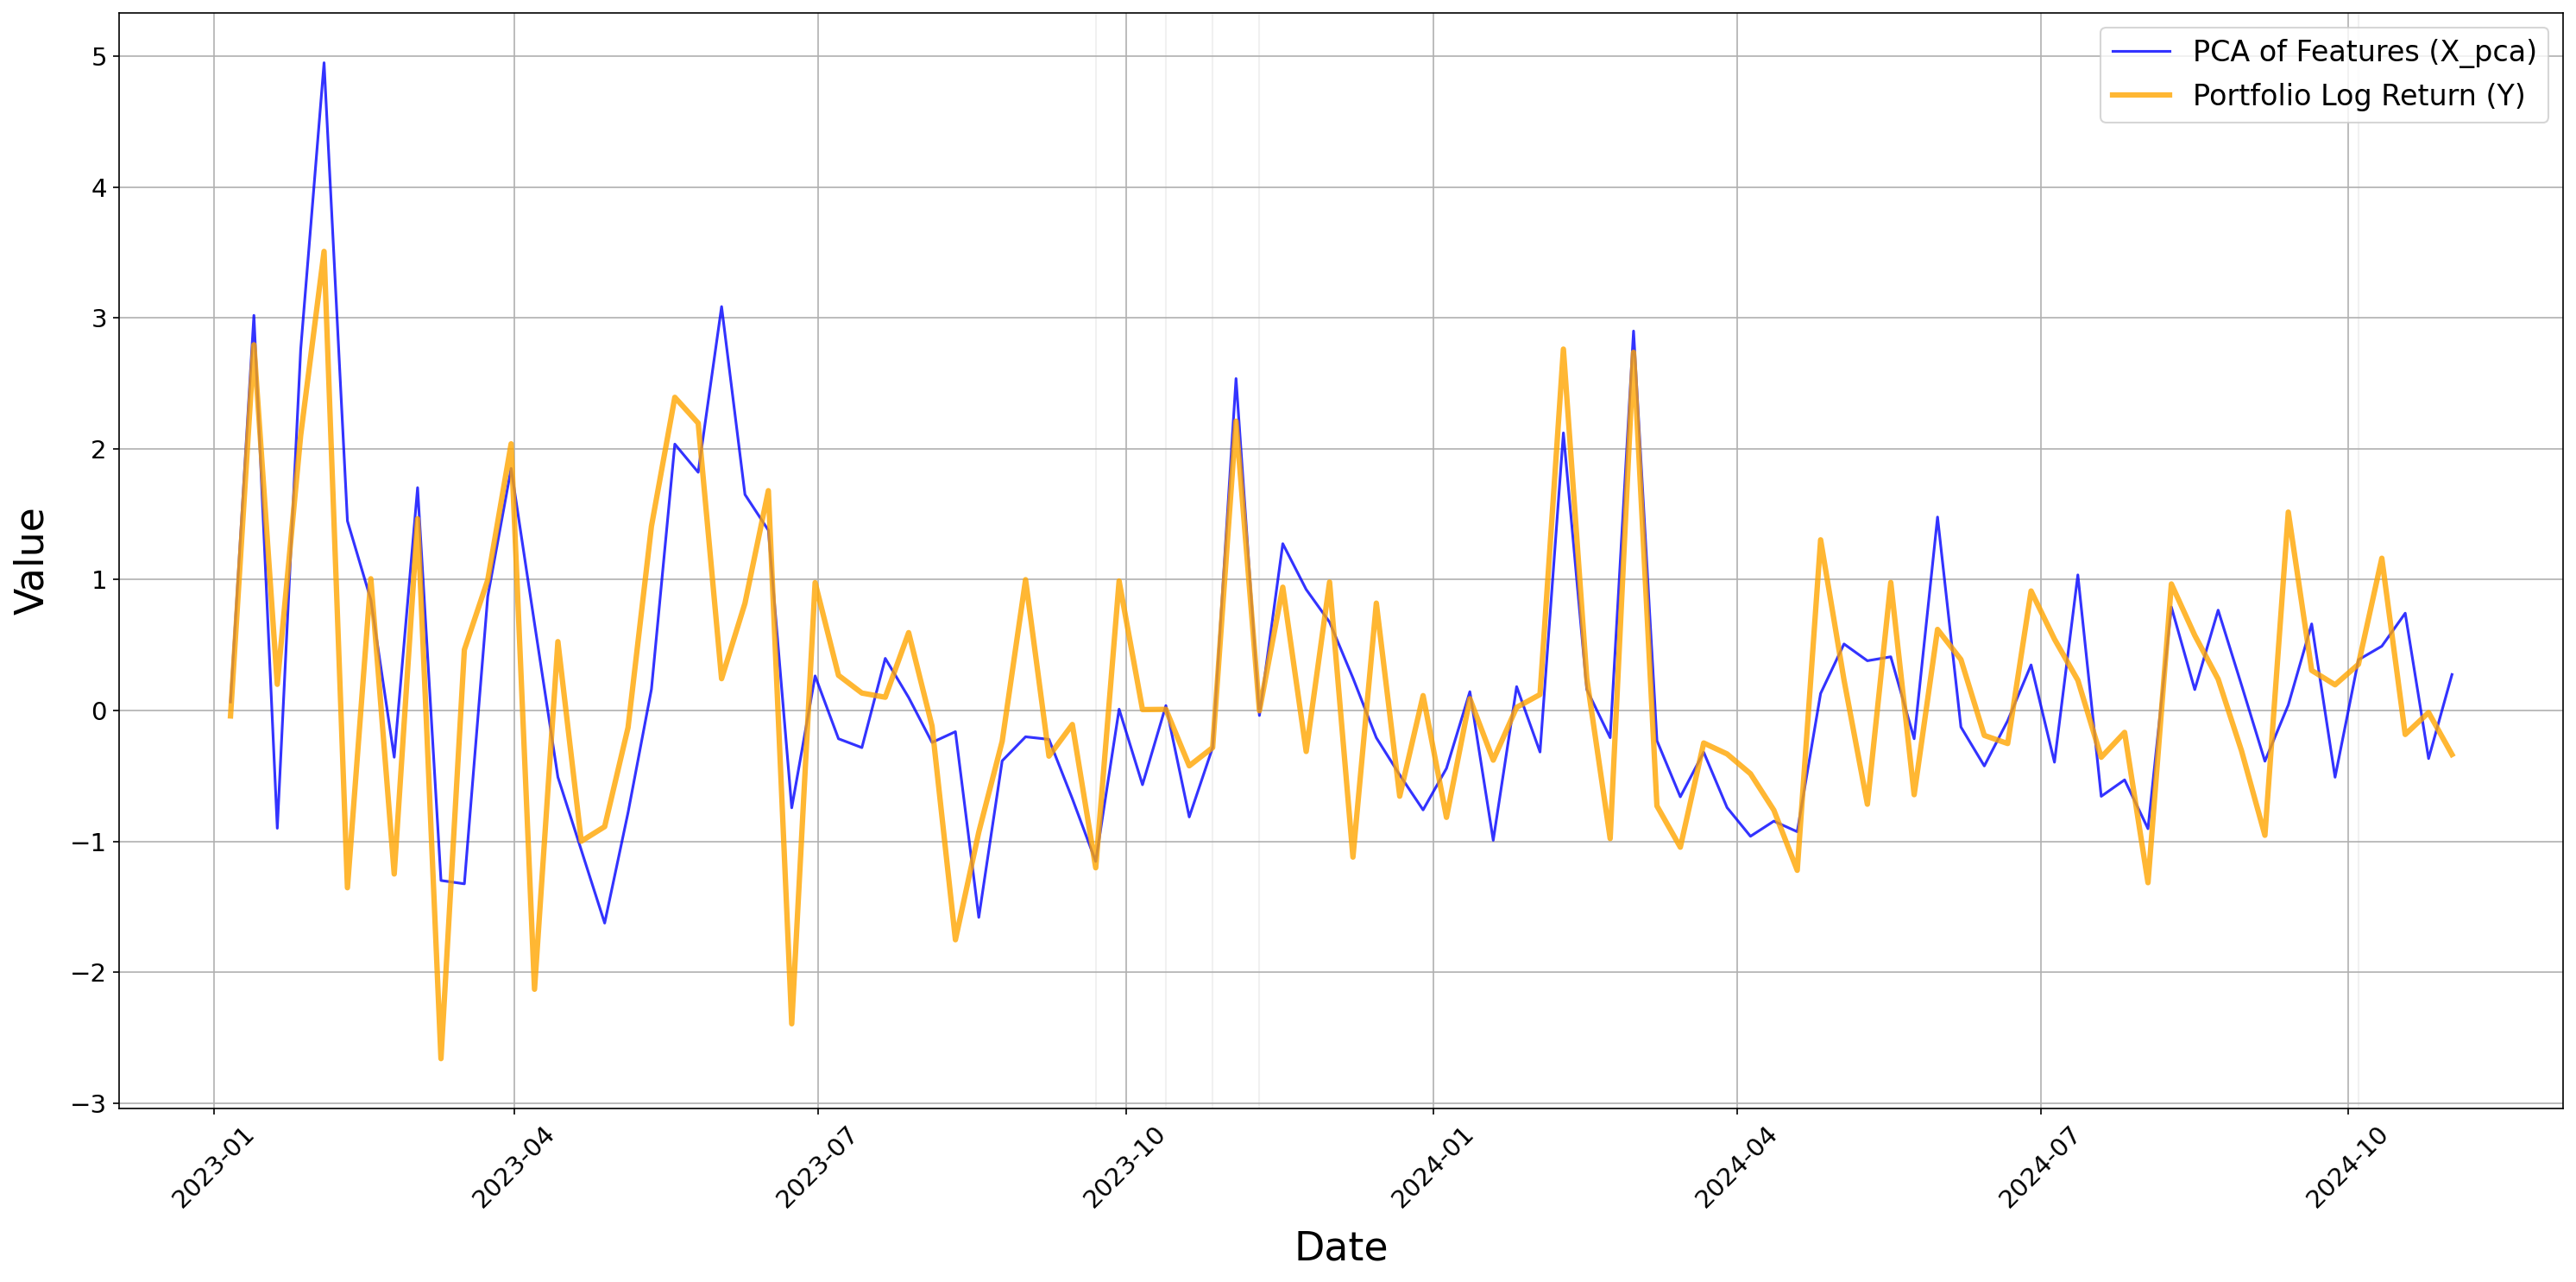

In [204]:
dates = portfolio['Date'].iloc[85:].reset_index(drop=True)
X_pca_slice = X_pca[85:].flatten()
Y_slice = Y[85:].values

threshold = 0.05
close_match = np.abs(X_pca_slice - Y_slice) < threshold
close_match_indices = np.where(close_match)[0]

intervals_post = []
if len(close_match_indices) > 0:
    start = close_match_indices[0]
    for i in range(1, len(close_match_indices)):
        if close_match_indices[i] != close_match_indices[i-1] + 1:
            intervals_post.append((start, close_match_indices[i-1]))
            start = close_match_indices[i]
    intervals_post.append((start, close_match_indices[-1]))

fig, ax = plt.subplots(figsize=(20, 10), dpi=150)
ax.plot(dates, X_pca_slice, label='PCA of Features (X_pca)',
        linewidth=1.5, alpha=0.8, color='blue')
ax.plot(dates, Y_slice, label='Portfolio Log Return (Y)', 
        linewidth=3, alpha=0.8, color='orange')

# start_of_ai_hype = pd.to_datetime('2023-01-01')
# ax.axvline(start_of_ai_hype, color='red', linestyle='--', linewidth=2, 
#            label='Start of AI Hype (2023-01-01)')

for (start_idx, end_idx) in intervals_post:
    ax.axvspan(dates[start_idx], dates[end_idx], color='lightgrey', alpha=0.3)

#ax.set_title('PCA of Features vs. Portfolio Log Return', fontsize=20, pad=20)
ax.set_xlabel('Date', fontsize=22, labelpad=10)
ax.set_ylabel('Value', fontsize=22, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=16)
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [205]:
len(intervals_post)

5

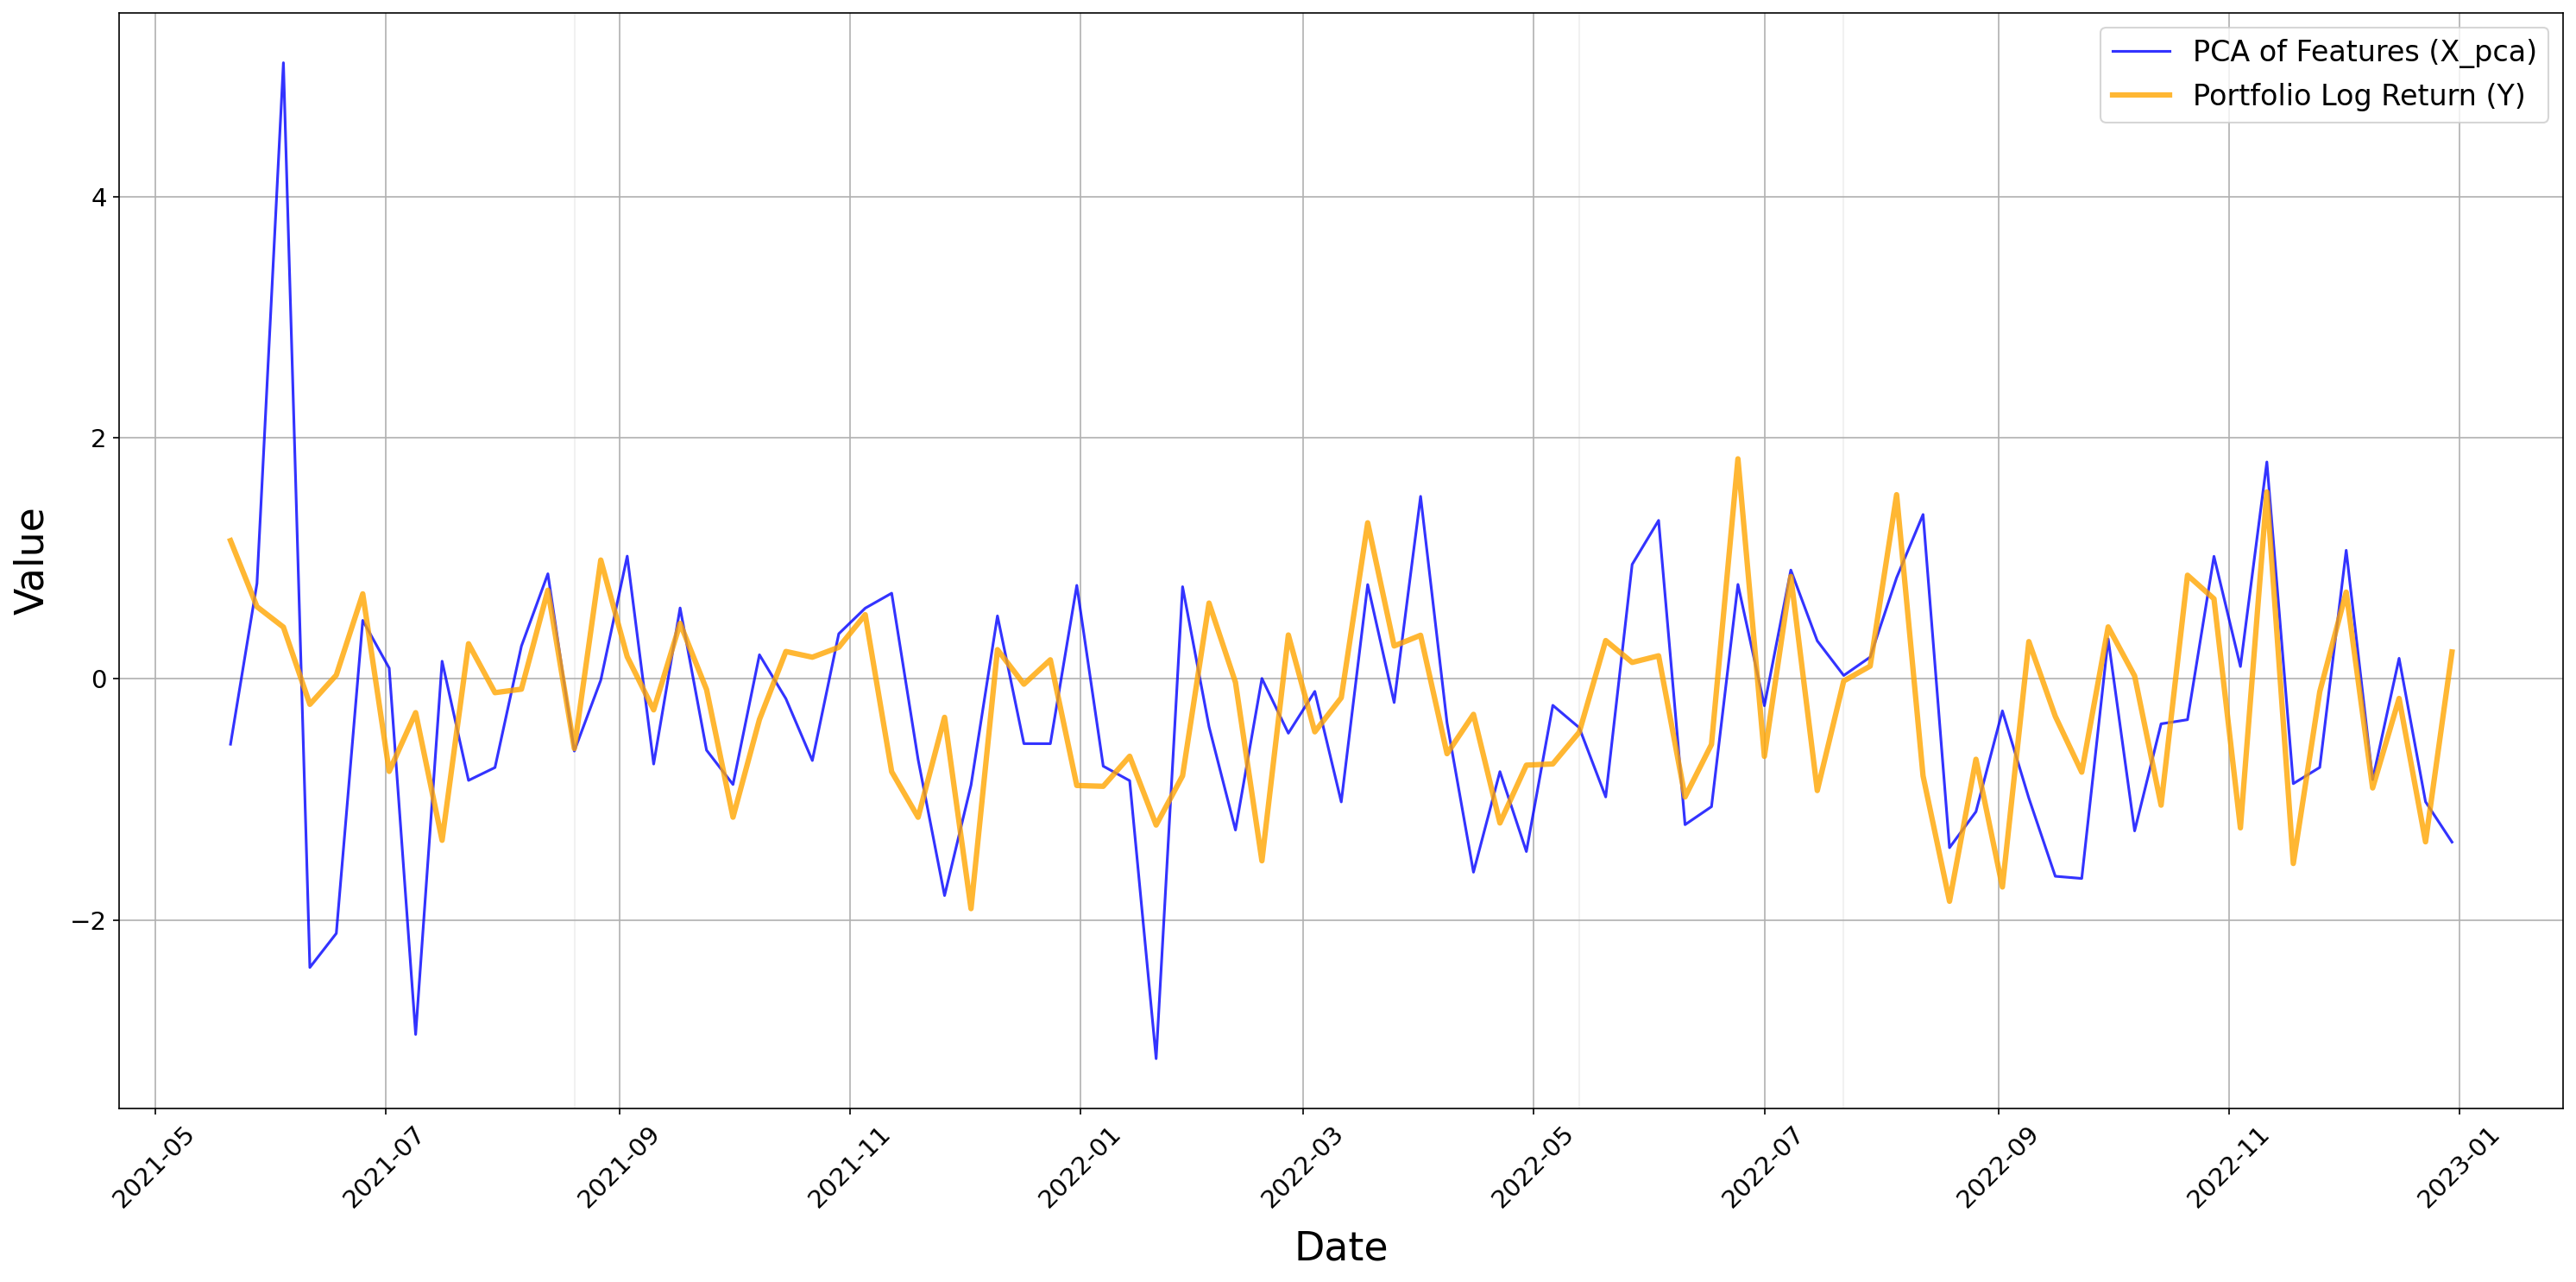

In [202]:
dates = portfolio['Date'].iloc[:85].reset_index(drop=True)
X_pca_slice = X_pca[:85].flatten()
Y_slice = Y[:85].values

threshold = 0.05
close_match = np.abs(X_pca_slice - Y_slice) < threshold
close_match_indices = np.where(close_match)[0]

intervals_pre = []
if len(close_match_indices) > 0:
    start = close_match_indices[0]
    for i in range(1, len(close_match_indices)):
        if close_match_indices[i] != close_match_indices[i-1] + 1:
            intervals_pre.append((start, close_match_indices[i-1]))
            start = close_match_indices[i]
    intervals_pre.append((start, close_match_indices[-1]))

fig, ax = plt.subplots(figsize=(20, 10), dpi=150)
ax.plot(dates, X_pca_slice, label='PCA of Features (X_pca)',
        linewidth=1.5, alpha=0.8, color='blue')
ax.plot(dates, Y_slice, label='Portfolio Log Return (Y)', 
        linewidth=3, alpha=0.8, color='orange')

# start_of_ai_hype = pd.to_datetime('2023-01-01')
# ax.axvline(start_of_ai_hype, color='red', linestyle='--', linewidth=2, 
#            label='Start of AI Hype (2023-01-01)')

for (start_idx, end_idx) in intervals_pre:
    ax.axvspan(dates[start_idx], dates[end_idx], color='lightgrey', alpha=0.3)

#ax.set_title('PCA of Features vs. Portfolio Log Return', fontsize=20, pad=20)
ax.set_xlabel('Date', fontsize=22, labelpad=10)
ax.set_ylabel('Value', fontsize=22, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=16)
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [203]:
len(intervals_pre)

3

Testing our features with different models

In [382]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression

In [383]:
portfolio = pd.DataFrame()
portfolio['Date'] = pltr['Date']  # Align on the same dates
portfolio['Portfolio Log Return'] = portfolio_log_return
portfolio['Date'] = pd.to_datetime(portfolio['Date'])

portfolio.loc[portfolio['Portfolio Log Return'] < 0, 'Portfolio Log Return'] = 'Up'
portfolio.loc[portfolio['Portfolio Log Return'] != 'Up', 'Portfolio Log Return'] = 'Down'
portfolio = portfolio[4:]

C:\Users\tural\AppData\Local\Temp\ipykernel_10772\809893286.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  portfolio['Date'] = pd.to_datetime(portfolio['Date'])


In [384]:
portfolio['Portfolio Log Return'].value_counts()

Portfolio Log Return
Up      98
Down    83
Name: count, dtype: int64

In [385]:
data['Log Returns'] = portfolio['Portfolio Log Return']

In [386]:
data['Log Returns'] = data['Log Returns'].shift(-1)
data['Portfolio Log Return'] = data['Portfolio Log Return'].shift(-1)

In [387]:
data.dropna(inplace=True)

In [388]:
data

,Portfolio Log Return,d_ST Lag 2,d_ST Lag 1,d_ST,d_VXN,Momentum 4W,d_CEFD Lag 1,d_CEFD Lag 2,d_CEFD,Log Returns
4,0.599256,0.923899,0.854190,-1.605248,-0.291029,-0.367342,0.030459,0.304929,-0.244485,Down
5,0.429735,0.854190,-1.605248,0.341820,-1.289575,-0.099678,-0.244485,0.030459,-0.126587,Down
6,-0.210707,-1.605248,0.341820,0.916620,-0.109382,0.589927,-0.126587,-0.244485,-2.386599,Up
7,0.031858,0.341820,0.916620,0.655403,-1.052325,0.595113,-2.386599,-0.126587,1.949492,Up
8,0.705930,0.916620,0.655403,-0.931871,1.615029,0.019636,1.949492,-2.386599,0.619314,Down
...,...,...,...,...,...,...,...,...,...,...
179,0.353910,-0.739859,0.548978,-1.466745,-0.161111,0.503049,-0.004173,0.146177,0.036311,Down
180,1.163798,0.548978,-1.466745,-0.131148,0.785516,1.049165,0.036311,-0.004173,-0.059370,Down
181,-0.182273,-1.466745,-0.131148,0.504159,0.751288,0.875164,-0.059370,0.036311,0.027667,Up
182,-0.014582,-0.131148,0.504159,0.144159,-0.701374,0.595237,0.027667,-0.059370,-0.045374,Up


In [389]:
X = data[['d_ST Lag 2', 'd_ST Lag 1', 'd_ST', 'Momentum 4W', 'd_VXN','d_CEFD']]

y_cat = data['Log Returns']
y_num = data['Portfolio Log Return']

Random Forest Classifier with Hyperparameter Tuning to predict log returns for next week

In [393]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [390]:
# Hyperparameter Tuning
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 3)]
max_depth = [int(x) for x in np.linspace(3, 11, num = 6)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }

In [391]:
random_grid

{'n_estimators': [50, 100, 150],
 'max_depth': [3, 4, 6, 7, 9, 11],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]}

In [394]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X, y_cat)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 6, 7, 9, 11],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42, verbose=2)

In [395]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 4}

In [418]:
# Random Forest Classifier

scoring = ['precision_macro', 'recall_macro']

model_2 = RandomForestClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_depth=4)

scores = cross_validate(model_2, X, y_cat, scoring=scoring, 
                       cv=10, return_train_score=True)
sorted(scores.keys())
scores['test_recall_macro'].mean()

0.5473611111111111

QQplots

Text(0.5, 1.0, 'Q-Q Plot of Momentum')

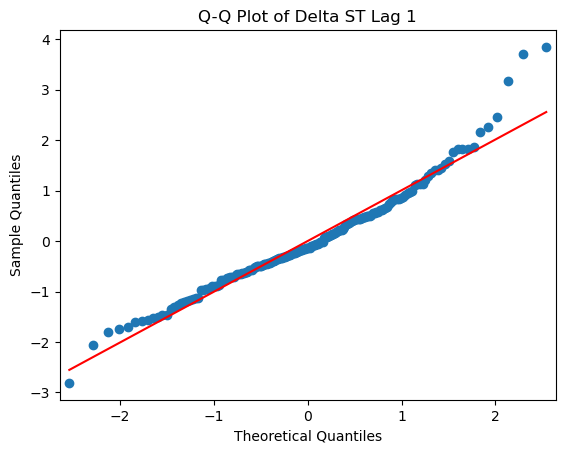

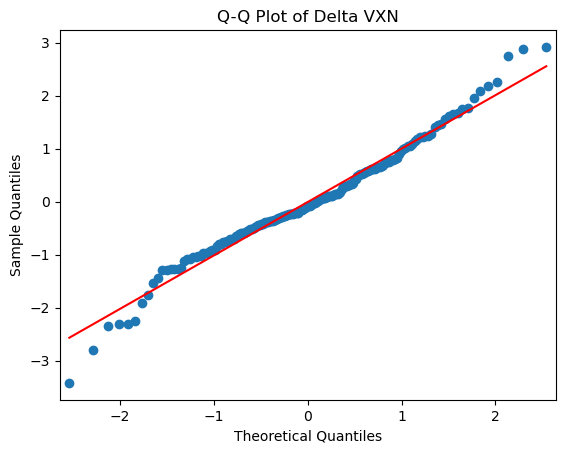

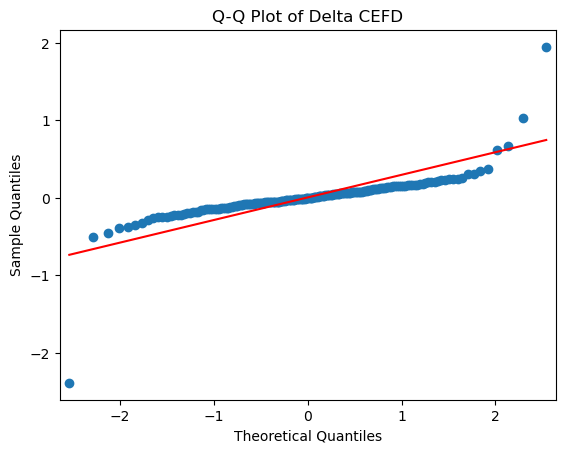

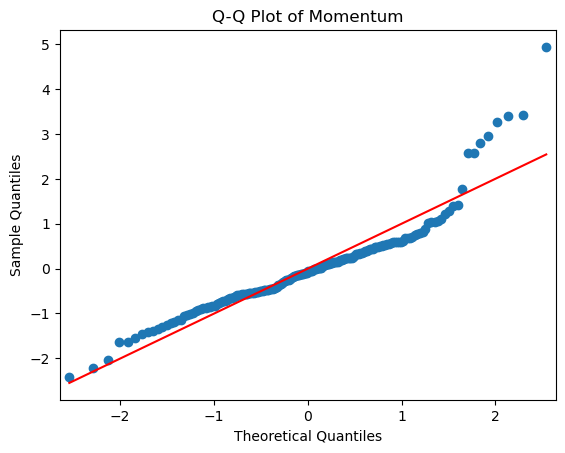

In [419]:
from scipy.stats import shapiro, normaltest, anderson

# Convert to a DataFrame for analysis
sm.qqplot(pd.Series(data['d_ST Lag 1']), line='s')
plt.title("Q-Q Plot of Delta ST Lag 1")

sm.qqplot(pd.Series(data['d_VXN']), line='s')
plt.title("Q-Q Plot of Delta VXN")

sm.qqplot(pd.Series(data['d_CEFD']), line='s')
plt.title("Q-Q Plot of Delta CEFD")

sm.qqplot(pd.Series(data['Momentum 4W']), line='s')
plt.title("Q-Q Plot of Momentum")
